# 03_model_training.ipynb
# Import necessary packages


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Load data and define train/test


In [51]:
# Change this path if you want to load a different file
data_path = "../data/processed/sp500_cleaned_model_ready.csv"

print(f"🔹 Loading dataset from: {data_path}")
df = pd.read_csv(data_path, index_col=0, parse_dates=True)
print(f"Dataset shape: {df.shape}")

# Define features & target
# (If you want to remove low-correlation features, do it here)
feature_cols = [col for col in df.columns if col not in ["Tomorrow", "Target"]]
X = df[feature_cols]
y = df["Target"]

# Time-based split
train_cutoff = "2024-01-01"
X_train = X[df.index < train_cutoff]
y_train = y[df.index < train_cutoff]

X_test = X[df.index >= train_cutoff]
y_test = y[df.index >= train_cutoff]

print(f"🔹 Train set: {X_train.shape}, Test set: {X_test.shape}")

🔹 Loading dataset from: ../data/processed/sp500_cleaned_model_ready.csv
Dataset shape: (7872, 45)
🔹 Train set: (7565, 44), Test set: (307, 44)


# Define models and hyperparams

In [52]:
models = {
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42, class_weight='balanced'),
        "params": {
            "n_estimators": [50, 100, 200],
            "min_samples_split": [2, 10, 50]
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100],
            "learning_rate": [0.01, 0.1],
            "max_depth": [3, 5]
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(solver='liblinear', class_weight='balanced'),
        "params": {
            "C": [0.1, 1, 10]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        "params": {
            "n_estimators": [100],
            "max_depth": [3, 5],
            "learning_rate": [0.01, 0.1]
        }
    }
}

# Train each model with GridSearch + eval


In [53]:
results = []
best_models = {}

for name, config in models.items():
    print(f"\nTraining {name} ...")
    grid = GridSearchCV(
        estimator=config["model"],
        param_grid=config["params"],
        cv=5,                
        scoring="precision", 
        n_jobs=-1           
    )
    grid.fit(X_train, y_train)
    
    # Best estimator and predictions
    best_estimator = grid.best_estimator_
    y_pred = best_estimator.predict(X_test)
    prec = precision_score(y_test, y_pred, zero_division=0)

    print(f"   Best Params: {grid.best_params_}")
    print(f"   Test Precision: {prec:.4f}")

    # Optional: classification report
    print("\n   Classification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Optional: confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("   Confusion Matrix:")
    print(cm)

    # Collect results
    results.append({
        "Model": name,
        "Best Precision": prec,
        "Best Params": grid.best_params_
    })
    best_models[name] = best_estimator


Training RandomForest ...
   Best Params: {'min_samples_split': 50, 'n_estimators': 200}
   Test Precision: 0.9558

   Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.96      0.78       133
           1       0.96      0.62      0.75       174

    accuracy                           0.77       307
   macro avg       0.81      0.79      0.77       307
weighted avg       0.83      0.77      0.77       307

   Confusion Matrix:
[[128   5]
 [ 66 108]]

Training GradientBoosting ...
   Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
   Test Precision: 0.8805

   Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       133
           1       0.88      0.80      0.84       174

    accuracy                           0.83       307
   macro avg       0.83      0.83      0.83       307
weighted avg       0.83      0.83      0.83       307



c:\Machine Learning Projects\stock-market-direction-prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:43:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


   Best Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
   Test Precision: 0.8994

   Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       133
           1       0.90      0.87      0.89       174

    accuracy                           0.87       307
   macro avg       0.87      0.87      0.87       307
weighted avg       0.87      0.87      0.87       307

   Confusion Matrix:
[[116  17]
 [ 22 152]]


# Summarize and visualize



Model training results saved to ../reports/model_training_results.csv


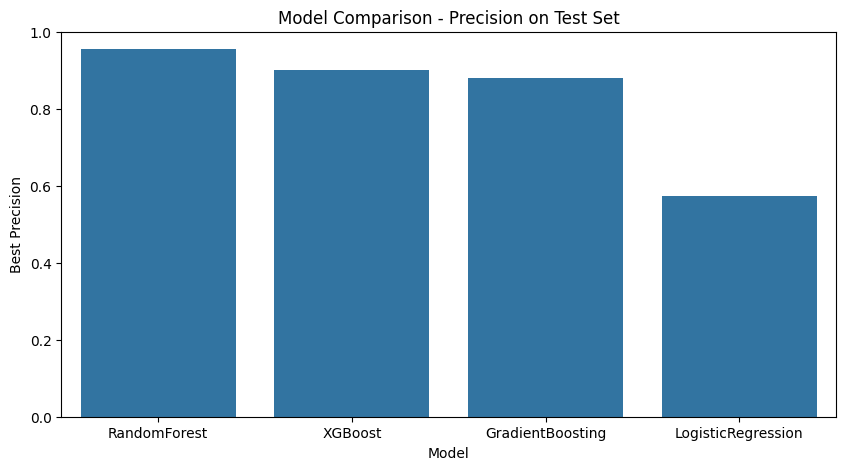

In [54]:
results_df = pd.DataFrame(results).sort_values(by="Best Precision", ascending=False)

# Make sure directories exist
os.makedirs("../reports/images/model", exist_ok=True)
os.makedirs("../reports", exist_ok=True)

# Save results to CSV
results_df.to_csv("../reports/model_training_results.csv", index=False)
print("\nModel training results saved to ../reports/model_training_results.csv")

# Plot bar chart
plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="Best Precision", data=results_df)
plt.title("Model Comparison - Precision on Test Set")
plt.ylim(0, 1)
plt.savefig("../reports/images/model/precision_comparison.png")
plt.show()

# Save the best model

In [55]:
best_model_name = results_df.iloc[0]["Model"]
best_model = best_models[best_model_name]

os.makedirs("../models", exist_ok=True)
model_path = f"../models/best_model_{best_model_name}.pkl"
joblib.dump(best_model, model_path)

print(f"\nBest model '{best_model_name}' saved to {model_path}")
print("\nTraining pipeline complete!")


Best model 'RandomForest' saved to ../models/best_model_RandomForest.pkl

Training pipeline complete!
